In [1]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
# !pip install efficientnet_pytorch
# !pip install albumentations

In [40]:
import os
import time
import skimage.io
import numpy as np
import pandas as pd
# import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm
from glob import glob

In [41]:
DEBUG=False

In [42]:
data_dir = './cropped_img/'
df_train = pd.read_csv(os.path.join(data_dir, 'labels_256.csv'))
image_folder = os.path.join(data_dir, 'train_256')

kernel_type = 'efficient_base_256'

enet_type = 'efficientnet-b0'
fold = 0
# tile_size = 256
image_size = 256
# n_tiles = 36
batch_size = 128
num_workers = 8
out_dim = 6
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 20
df_train = df_train.sample(30000).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

./cropped_img/train_256


In [43]:
df_train

,image_id,label
0,6071aa8ba6c71f822201674f662a2058_44.png,2
1,5d5ba6a776e985a917f0028258d6593a_13.png,1
2,e89fd05c02c2297653d93f9bdaa71961_0.png,2
3,9b238129762edd83f472e5b3abf9e639_9.png,2
4,f83af16db53783f37f6614cf3bc3e5af_44.png,5
...,...,...
260440,a21ea7caca40bc45f043ed27ae2b573d_11.png,3
260441,38be72b06e0e96e493a90c4f583a6e10_80.png,0
260442,b0db6c7062db390ce41581728f2ef122_5.png,0
260443,eb341a42f1e27d3af125fa1bcba8c799_25.png,3


In [44]:
clearn_img=df_train['image_id'].values

In [45]:
marked_img=glob('./marker-images/*')
marked_img=[name.split('/')[2].split('.')[0] for name in marked_img]

In [46]:
clearn_img=[i for i,name in enumerate(clearn_img) if name.split('_')[0] not in marked_img ]

In [47]:
df_train.loc[clearn_img,:]

,image_id,label
0,6071aa8ba6c71f822201674f662a2058_44.png,2
1,5d5ba6a776e985a917f0028258d6593a_13.png,1
2,e89fd05c02c2297653d93f9bdaa71961_0.png,2
3,9b238129762edd83f472e5b3abf9e639_9.png,2
4,f83af16db53783f37f6614cf3bc3e5af_44.png,5
...,...,...
260440,a21ea7caca40bc45f043ed27ae2b573d_11.png,3
260441,38be72b06e0e96e493a90c4f583a6e10_80.png,0
260442,b0db6c7062db390ce41581728f2ef122_5.png,0
260443,eb341a42f1e27d3af125fa1bcba8c799_25.png,3


In [5]:
skf = StratifiedKFold(10, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,label,fold
0,6071aa8ba6c71f822201674f662a2058_44.png,2,1
1,5d5ba6a776e985a917f0028258d6593a_13.png,1,9
2,e89fd05c02c2297653d93f9bdaa71961_0.png,2,4
3,9b238129762edd83f472e5b3abf9e639_9.png,2,1
4,f83af16db53783f37f6614cf3bc3e5af_44.png,5,0


In [6]:
pretrained_model = {
    'efficientnet-b0': 'efficientnet-b0-08094119.pth'
}

In [7]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_model[backbone]))

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x
#         return F.log_softmax(x,dim=0)

In [8]:
class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        cropped_img=os.path.join(image_folder, img_id)
        image = skimage.io.MultiImage(cropped_img)[0] #.png
        image=np.asarray(image)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.astype(np.float32)
        image /= 255
        image = image.transpose(2, 0, 1)

        # label = np.zeros(5).astype(np.float32)
        # label[row.label] = 1.
        label=np.array(row.label).astype(int)
        return torch.tensor(image), torch.tensor(label)



In [9]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

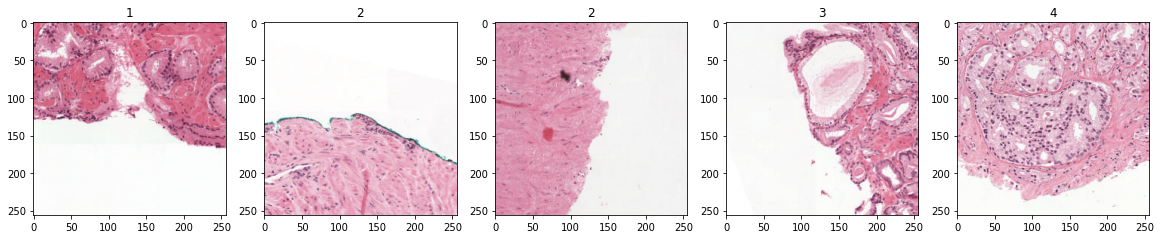

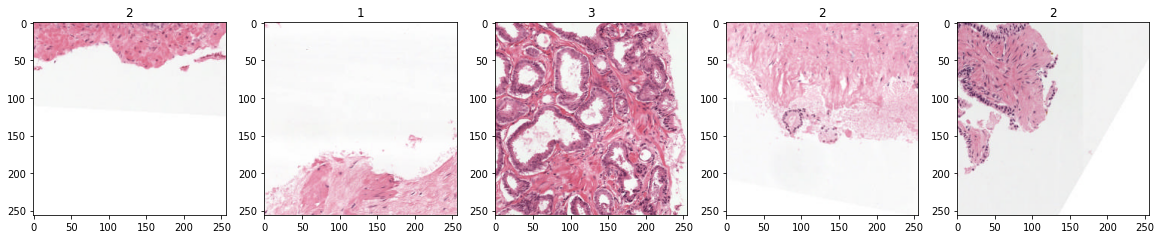

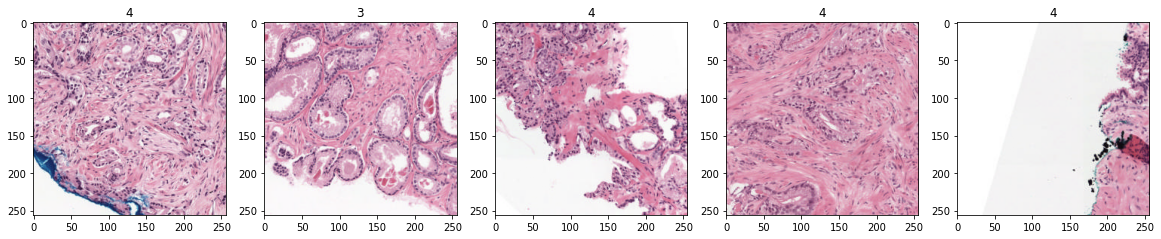

In [10]:
dataset_show = PANDADataset(df_train, image_size, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        # axarr[p].set_title(str(np.where(label==1)[0]))
        axarr[p].set_title(str(np.array(label).astype(int)))


In [11]:
# criterion = nn.BCEWithLogitsLoss()
criterion=nn.CrossEntropyLoss()

In [12]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)
            loss = criterion(logits, target)

            # pred = logits.sigmoid().detach()
            pred=logits.argmax(1).detach()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    # PREDS = np.argmax(torch.cat(PREDS).cpu().numpy(),axis=1)
    # TARGETS = np.argmax(torch.cat(TARGETS).cpu().numpy(),axis=1)
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean()
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

In [13]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

234400 26045


In [14]:
qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Mon Jul  6 13:03:53 2020 Epoch: 1


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 13:18:46 2020 Epoch 1, lr: 0.0000300, train loss: 0.71829, val loss: 0.57049, acc: 0.77911, qwk: 0.89693
score2 (0.000000 --> 0.896932).  Saving model ...
Mon Jul  6 13:18:46 2020 Epoch: 2


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 13:33:35 2020 Epoch 2, lr: 0.0003000, train loss: 0.54823, val loss: 0.51274, acc: 0.80403, qwk: 0.90574
score2 (0.896932 --> 0.905737).  Saving model ...
Mon Jul  6 13:33:35 2020 Epoch: 3


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 13:48:24 2020 Epoch 3, lr: 0.0000300, train loss: 0.46821, val loss: 0.45860, acc: 0.82231, qwk: 0.91911
score2 (0.905737 --> 0.919107).  Saving model ...
Mon Jul  6 13:48:24 2020 Epoch: 4


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 14:03:15 2020 Epoch 4, lr: 0.0002919, train loss: 0.48301, val loss: 0.46995, acc: 0.81805, qwk: 0.91239
Mon Jul  6 14:03:15 2020 Epoch: 5


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 14:18:13 2020 Epoch 5, lr: 0.0002819, train loss: 0.44752, val loss: 0.46746, acc: 0.82116, qwk: 0.91918
score2 (0.919107 --> 0.919181).  Saving model ...
Mon Jul  6 14:18:13 2020 Epoch: 6


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 14:33:09 2020 Epoch 6, lr: 0.0002684, train loss: 0.41783, val loss: 0.45601, acc: 0.82676, qwk: 0.92167
score2 (0.919181 --> 0.921674).  Saving model ...
Mon Jul  6 14:33:09 2020 Epoch: 7


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 14:48:14 2020 Epoch 7, lr: 0.0002516, train loss: 0.38783, val loss: 0.44574, acc: 0.83413, qwk: 0.92416
score2 (0.921674 --> 0.924158).  Saving model ...
Mon Jul  6 14:48:14 2020 Epoch: 8


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 15:03:15 2020 Epoch 8, lr: 0.0002320, train loss: 0.36069, val loss: 0.44757, acc: 0.83413, qwk: 0.92372
Mon Jul  6 15:03:15 2020 Epoch: 9


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 15:18:18 2020 Epoch 9, lr: 0.0002103, train loss: 0.33100, val loss: 0.42693, acc: 0.84243, qwk: 0.92808
score2 (0.924158 --> 0.928077).  Saving model ...
Mon Jul  6 15:18:18 2020 Epoch: 10


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 15:33:16 2020 Epoch 10, lr: 0.0001868, train loss: 0.30166, val loss: 0.42251, acc: 0.84604, qwk: 0.92881
score2 (0.928077 --> 0.928808).  Saving model ...
Mon Jul  6 15:33:16 2020 Epoch: 11


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 15:48:18 2020 Epoch 11, lr: 0.0001624, train loss: 0.27017, val loss: 0.46898, acc: 0.84158, qwk: 0.92481
Mon Jul  6 15:48:18 2020 Epoch: 12


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 16:03:16 2020 Epoch 12, lr: 0.0001376, train loss: 0.24394, val loss: 0.43551, acc: 0.85318, qwk: 0.93014
score2 (0.928808 --> 0.930142).  Saving model ...
Mon Jul  6 16:03:16 2020 Epoch: 13


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 16:18:16 2020 Epoch 13, lr: 0.0001132, train loss: 0.21579, val loss: 0.45357, acc: 0.85014, qwk: 0.92864
Mon Jul  6 16:18:16 2020 Epoch: 14


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 16:33:17 2020 Epoch 14, lr: 0.0000897, train loss: 0.19106, val loss: 0.46527, acc: 0.85014, qwk: 0.92815
Mon Jul  6 16:33:17 2020 Epoch: 15


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 16:48:17 2020 Epoch 15, lr: 0.0000680, train loss: 0.17068, val loss: 0.48198, acc: 0.85229, qwk: 0.92920
Mon Jul  6 16:48:17 2020 Epoch: 16


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 17:03:18 2020 Epoch 16, lr: 0.0000484, train loss: 0.15176, val loss: 0.50436, acc: 0.85348, qwk: 0.93052
score2 (0.930142 --> 0.930518).  Saving model ...
Mon Jul  6 17:03:18 2020 Epoch: 17


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 17:18:17 2020 Epoch 17, lr: 0.0000316, train loss: 0.13955, val loss: 0.51051, acc: 0.85333, qwk: 0.92943
Mon Jul  6 17:18:17 2020 Epoch: 18


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 17:33:11 2020 Epoch 18, lr: 0.0000181, train loss: 0.12947, val loss: 0.51657, acc: 0.85383, qwk: 0.92960
Mon Jul  6 17:33:11 2020 Epoch: 19


  0%|          | 0/1832 [00:00<?, ?it/s]

Mon Jul  6 17:48:01 2020 Epoch 19, lr: 0.0000081, train loss: 0.12208, val loss: 0.52341, acc: 0.85467, qwk: 0.92999
Mon Jul  6 17:48:01 2020 Epoch: 20


100%|██████████| 204/204 [00:32<00:00,  6.33it/s]


Mon Jul  6 18:02:55 2020 Epoch 20, lr: 0.0000020, train loss: 0.11961, val loss: 0.52546, acc: 0.85510, qwk: 0.93026
